<a href="https://colab.research.google.com/github/Tama101/payment_late_prediction/blob/main/PAYMENT_PUNCTUATION_PREDICTION_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD DATA

In [1]:
try:
    from gspread_dataframe import set_with_dataframe
except ImportError:
    !pip install -q gspread_dataframe --quite
    !pip install -q openpyxl xlrd --quite
    from gspread_dataframe import set_with_dataframe

from google.colab import files, drive, auth
import io
import gspread as gd
import pandas as pd
import numpy as np
from google.auth import default
import warnings
import time
warnings.simplefilter("ignore", UserWarning)

# EXTRACT AND TRANSFORM DATA
drive.mount('/content/drive'); auth.authenticate_user(); creds, _ = default()
pd.set_option('display.max_columns', None)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# DATA CUSTOMER
cust_data = pd.DataFrame(gd.authorize(creds).open('raw_data_cust').worksheet('raw_data_cust').get_all_values()[1:],
             columns=gd.authorize(creds).open('raw_data_cust').worksheet('raw_data_cust').get_all_values()[0])

In [3]:
# SALES DATA
sales_data = pd.DataFrame(gd.authorize(creds).open('MONITORING SALES ORDER - PELINDA 2024').worksheet('raw_2025').get_all_values()[1:],
             columns=gd.authorize(creds).open('MONITORING SALES ORDER - PELINDA 2024').worksheet('raw_2025').get_all_values()[0])

In [4]:
number_product = sales_data[['invoice', 'product_id']].groupby('invoice')['product_id'].nunique().astype(int).reset_index().sort_values(by='product_id', ascending=False).rename(columns={'product_id': 'number_product'})

In [5]:
# UPLOAD EXCEL AR PAYMENT
ar_payment = (
    pd.read_excel(io.BytesIO(next(iter(files.upload().values()))), dtype=str)
    .rename(columns={
        'INVOICE': 'invoice',
        'ID PELANGGAN': 'cust_id',
        'TGL INVOICE': 'invoice_date',
        'TGL PEMBAYARAN': 'payment_date',
        'TGL JT. INVOICE': 'due_date',
        'NILAI INVOICE': 'inv_value',
        'TGL PEMBAYARAN TERAKHIR': 'last_payment_date',
        'PEMBAYARAN TERLAMBAT (HARI)': 'over_due',
        'SISA PEMBAYARAN': 'remaining_inv'
    })
    .assign(
        invoice_date=lambda x: pd.to_datetime(x['invoice_date'], errors='coerce'),
        due_date=lambda x: pd.to_datetime(x['due_date'], errors='coerce'),
        last_payment_date=lambda x: pd.to_datetime(x['last_payment_date'], errors='coerce').dt.strftime('%Y-%m-%d'),
        over_due=lambda x: x['over_due'].astype(int),
        remaining_inv=lambda x: x['remaining_inv'].astype(float),
        inv_value=lambda x: x['inv_value'].astype(float),
        cust_id=lambda x: x['cust_id'].astype(str),
        invoice=lambda x: x['invoice'].astype(str)
    )
    .merge(
        cust_data[['Id Pelanggan', 'Kategori 1', 'Propinsi', 'Kecamatan']],
        left_on='cust_id',
        right_on='Id Pelanggan',
        how='left'
    )
    .rename(columns={
        'Kategori 1': 'channel',
        'Propinsi': 'province',
        'Kecamatan': 'kecamatan'
    })
    .loc[lambda df: df['remaining_inv'] == 0]
    .drop(columns=['Id Pelanggan', 'remaining_inv', 'over_due'])
    .assign(
        inv_month=lambda df: df['invoice_date'].dt.month,
        inv_day=lambda df: df['invoice_date'].dt.day,
        inv_year=lambda df: df['invoice_date'].dt.year,
        payment_late=lambda df: (pd.to_datetime(df['last_payment_date']) - pd.to_datetime(df['due_date'])).dt.days,
        payment_status=lambda df: np.where(df['payment_late'] > 14, 'bad', 'good')
    )
    .query("inv_year == 2024 & inv_value > 0")
    .drop(columns=['invoice_date', 'due_date', 'last_payment_date', 'cust_id', 'inv_year', 'payment_late'])
    .reset_index(drop=True)
    .merge(number_product, on='invoice', how='left')
    .dropna(subset=['number_product'])
    .assign(number_product=lambda x: x['number_product'].astype(int))
    .drop(columns=['invoice'])
)


Saving LAPORAN AR PAYMENT.20.03.2025.xlsx to LAPORAN AR PAYMENT.20.03.2025 (16).xlsx


In [6]:
pd.DataFrame({
    'Data Type': ar_payment.dtypes,
    'Missing Values': ar_payment.isna().sum()
})

,Data Type,Missing Values
inv_value,float64,0
channel,object,0
province,object,0
kecamatan,object,0
inv_month,int32,0
inv_day,int32,0
payment_status,object,0
number_product,int64,0


In [7]:
ar_payment.sample(n=10)

,inv_value,channel,province,kecamatan,inv_month,inv_day,payment_status,number_product
974,6960000.00,GT,Jawa Timur,Pabean Cantikan,6,24,good,10
2346,5795024.00,MT,DKI Jakarta,Tebet,12,23,good,18
2182,2958737.00,MT,DKI Jakarta,Pademangan,10,24,bad,24
1246,3000800.00,MT,DKI Jakarta,Tanjung Priok,7,19,good,37
1601,640851.84,MT,DKI Jakarta,Penjaringan,8,22,bad,1
1911,1232000.88,GT,DKI Jakarta,Tambora,9,24,good,1
177,720225.00,MT,DKI Jakarta,Tanjung Priok,2,27,good,17
2308,1320000.00,GT,Jawa Barat,Bekasi Utara,11,21,good,2
671,5236800.00,GT,DKI Jakarta,Duren Sawit,5,20,bad,25
700,2041200.00,GT,DKI Jakarta,Pademangan,5,27,bad,2


# OUTLIER

In [8]:
numcols = ar_payment.select_dtypes(exclude=['object']).columns.tolist()
catcols = ar_payment.select_dtypes(include=['object']).columns.tolist()

In [9]:
def calculate_outlier_percentage(df):
    numeric_cols = df.select_dtypes(include=['number']).columns  # select only numerical columns
    outlier_percentages = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        total_count = len(df[col])
        outlier_percentage = (outlier_count / total_count) * 100  # convert to percentage

        outlier_percentages[col] = outlier_percentage

    return outlier_percentages


In [10]:
print(pd.DataFrame(list(calculate_outlier_percentage(ar_payment).items()),
                   columns=['Column', 'Outlier Percentage']).round(2))

           Column  Outlier Percentage
0       inv_value                9.25
1       inv_month                0.00
2         inv_day                0.00
3  number_product               12.44


In [11]:
# remove outlier

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [12]:
ar_clean = remove_outliers(ar_payment, ['number_product'])

In [13]:
ar_clean

,inv_value,channel,province,kecamatan,inv_month,inv_day,payment_status,number_product
0,629640.00,MT,DKI Jakarta,Tebet,1,2,good,1
1,9428760.00,MT,DKI Jakarta,Tebet,1,2,good,1
2,16666165.00,MT,DKI Jakarta,Pademangan,1,2,good,1
3,5506800.00,MT,DKI Jakarta,Pademangan,1,3,good,1
4,1507500.00,MT,DKI Jakarta,Tambun Selatan,1,5,good,1
...,...,...,...,...,...,...,...,...
2353,3430500.00,EC,DKI Jakarta,Pademangan,12,28,good,10
2355,2472900.00,EC,DKI Jakarta,Pademangan,12,28,good,6
2356,8874806.00,EC,DKI Jakarta,Pademangan,12,28,good,5
2359,0.19,MT,DKI Jakarta,Penjaringan,7,15,good,1


In [14]:
ar_clean.payment_status.value_counts()

,count
payment_status,
good,1269
bad,786


# UNDERSAMPLING

In [15]:
from sklearn.model_selection import train_test_split

# Stratified undersampling to preserve distribution
ar_good_sample = ar_clean[ar_clean.payment_status == 'good']
ar_good_sample, _ = train_test_split(ar_good_sample, train_size=786, stratify=ar_good_sample[['payment_status']], random_state=42)

ar_bad_sample = ar_clean[ar_clean.payment_status == 'bad']


In [16]:
ar_balanced = pd.concat([
    ar_good_sample,
    ar_bad_sample
], axis=0).reset_index(drop=True)

In [17]:
ar_balanced.payment_status.value_counts()

,count
payment_status,
good,786
bad,786


In [18]:
ar_balanced

,inv_value,channel,province,kecamatan,inv_month,inv_day,payment_status,number_product
0,371200.0,GT,Banten,Pamulang,8,30,good,2
1,8000000.0,GT,Jawa Barat,Bogor Tengah,3,28,good,1
2,14658437.0,EC,DKI Jakarta,Pademangan,11,29,good,10
3,20075.0,MT,DKI Jakarta,Tanjung Priok,8,15,good,1
4,98400.0,GT,DKI Jakarta,Pademangan,7,29,good,5
...,...,...,...,...,...,...,...,...
1567,70400.0,GT,DKI Jakarta,Pademangan,10,22,bad,1
1568,1869000.0,MT,DKI Jakarta,Cilandak,10,22,bad,6
1569,2329195.0,MT,DKI Jakarta,Pademangan,10,23,bad,10
1570,230400.0,DB,Jawa Barat,Antapani (Cicadas),10,24,bad,1


interval columns not set, guessing: ['inv_value', 'inv_month', 'inv_day', 'number_product']


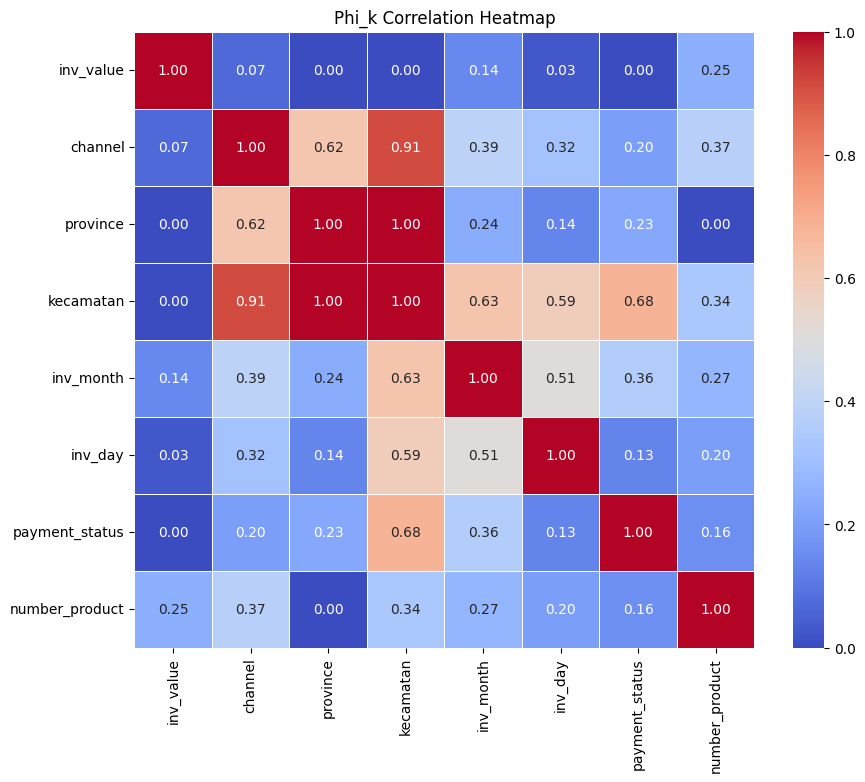

In [19]:
!pip install phik -q
import phik
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Phi_k correlation matrix
phik_matrix = ar_balanced.phik_matrix()

# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Phi_k Correlation Heatmap")
plt.show()


In [20]:
import pandas as pd
import phik
from scipy.stats import chi2_contingency

# 1️. Phi_k correlation
phik_matrix = ar_balanced.phik_matrix()
print("Phi_k correlation between kecamatan and payment_status:", phik_matrix.loc["kecamatan", "payment_status"])

# 2. Chi-Square Test
cross_tab = pd.crosstab(ar_balanced["kecamatan"], ar_balanced["payment_status"])
chi2, p, _, _ = chi2_contingency(cross_tab)
print(f"Chi-Square Test p-value: {p.round(4)}")

# 3. Analyze payment_status distribution per kecamatan
distribution = ar_balanced.groupby("kecamatan")["payment_status"].value_counts(normalize=True).unstack()
distribution.round(3).fillna('-')

interval columns not set, guessing: ['inv_value', 'inv_month', 'inv_day', 'number_product']
Phi_k correlation between kecamatan and payment_status: 0.679789602125146
Chi-Square Test p-value: 0.0


payment_status,bad,good
kecamatan,,
,0.545,0.455
Adiwerna,1.0,-
Ambarawa,0.75,0.25
Andir,-,1.0
Antapani (Cicadas),1.0,-
...,...,...
Temanggung,1.0,-
Tembalang,1.0,-
Ungaran Barat,1.0,-


1. Kecamatan memiliki korelasi kuat dengan payment_status -> kecamatan. Punya predictive power.

2. Chi-Square test p-value adalah 0. Kecamatan memiliki pengaruh kuat pada payment_status



In [21]:
# Compute Phi_k correlation for province
phi_k_province = ar_balanced[['province', 'payment_status']].phik_matrix().loc['province', 'payment_status']

# Chi-Square Test
from scipy.stats import chi2_contingency

province_ct = pd.crosstab(ar_balanced['province'], ar_balanced['payment_status'])
chi2, p_value, _, _ = chi2_contingency(province_ct)

# Payment status distribution per province
province_distribution = province_ct.div(province_ct.sum(axis=1), axis=0)

# Display results
print(f"Phi_k correlation between province and payment_status: {phi_k_province:.6f}")
print(f"Chi-Square Test p-value: {p_value:.40f}")  # Full number, no scientific notation
print("\nPayment status distribution by province:")
print(province_distribution)


Phi_k correlation between province and payment_status: 0.229992
Chi-Square Test p-value: 0.0000000129765901702581133252758992485502

Payment status distribution by province:
payment_status           bad      good
province                              
                    0.545455  0.454545
Bali                0.444444  0.555556
Banten              0.675393  0.324607
DI Yogyakarta       0.666667  0.333333
DKI Jakarta         0.428571  0.571429
Gorontalo           0.000000  1.000000
Jawa Barat          0.537954  0.462046
Jawa Tengah         0.680556  0.319444
Jawa Timur          0.519608  0.480392
Kalimantan Selatan  1.000000  0.000000
Kalimantan Timur    0.000000  1.000000
Kepulauan Riau      1.000000  0.000000
Papua               1.000000  0.000000
Riau                0.666667  0.333333


1. province memiliki phik (2%), lebih rendah dari kecamatan.
2. Chi-Square test p-value adalah 0. masih significant seperti kecamatan tapi nilai phik lebih rendah dari kecamatan.
3. province akan di drop dari feature.

In [22]:
ar_balanced2 = ar_balanced.drop(columns=['province'])

# SCALING

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define the pipeline
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ar_balanced2.select_dtypes(exclude=['object']).columns.tolist()),
        ('cat', categorical_transformer, ar_balanced2.select_dtypes(include=['object']).columns.tolist())
    ])



In [37]:
ar_scaled = pd.DataFrame(preprocessor.fit_transform(ar_balanced2),
                         columns=ar_balanced2.select_dtypes(exclude=['object']).columns.tolist() + ar_balanced2.select_dtypes(include=['object']).columns.tolist())

In [25]:
ar_scaled

,inv_value,inv_month,inv_day,number_product,channel,kecamatan,payment_status
0,-0.272567,0.25,0.733333,0.00,3.0,146.0,1.0
1,2.564984,-1.00,0.600000,-0.25,3.0,27.0,1.0
2,5.041607,1.00,0.666667,2.00,2.0,143.0,1.0
3,-0.403169,0.25,-0.266667,-0.25,4.0,203.0,1.0
4,-0.374036,0.00,0.666667,0.75,3.0,143.0,1.0
...,...,...,...,...,...,...,...
1567,-0.384451,0.75,0.200000,-0.25,3.0,143.0,0.0
1568,0.284543,0.75,0.200000,1.00,4.0,58.0,0.0
1569,0.455714,0.75,0.266667,2.00,4.0,143.0,0.0
1570,-0.324938,0.75,0.333333,-0.25,0.0,4.0,0.0


# SYNTHETIC DATA

In [26]:
import numpy as np

num_synthetic = 300000  # tambahkan sesuai kebutuhan

# Generate synthetic data by sampling existing data and adding noise
synthetic_data = ar_scaled.sample(n=num_synthetic, replace=True).reset_index(drop=True)

# add small Gaussian noise to numeric columns
for col in numcols:
    noise = np.random.normal(loc=0, scale=ar_scaled[col].std() * 0.1, size=num_synthetic)  # 10% of std dev
    synthetic_data[col] += noise

In [27]:
ar_new = pd.concat([ar_scaled, synthetic_data], axis=0).reset_index().drop(columns='index')

In [28]:
ar_new

,inv_value,inv_month,inv_day,number_product,channel,kecamatan,payment_status
0,-0.272567,0.250000,0.733333,0.000000,3.0,146.0,1.0
1,2.564984,-1.000000,0.600000,-0.250000,3.0,27.0,1.0
2,5.041607,1.000000,0.666667,2.000000,2.0,143.0,1.0
3,-0.403169,0.250000,-0.266667,-0.250000,4.0,203.0,1.0
4,-0.374036,0.000000,0.666667,0.750000,3.0,143.0,1.0
...,...,...,...,...,...,...,...
301567,5.111328,-1.541278,0.762455,-0.317733,3.0,196.0,1.0
301568,0.892184,-0.509414,-0.322936,2.412747,4.0,143.0,0.0
301569,1.175363,-0.553906,0.617858,2.761211,3.0,202.0,1.0
301570,1.581121,-1.548024,0.685423,1.588323,4.0,208.0,0.0


# SPLIT TRAIN & TEST DATA

In [29]:
x = ar_new.drop(columns='payment_status')
y = ar_new['payment_status']

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [31]:
print('train size :', x_train.shape)
print('test size :', x_test.shape)

train size : (211100, 6)
test size : (90472, 6)


# BUILD MODEL

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define Preprocessing Pipeline

# Splitting Data
x = ar_new.drop(columns='payment_status')
y = ar_new['payment_status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Train XGBoost Model
rf_model = RandomForestClassifier(
    n_estimators=11,  # Number of trees
    max_depth=20,  # Limiting depth for better generalization
    min_samples_split=5,  # Minimum samples to split a node
    min_samples_leaf=1,  # Minimum samples per leaf
    random_state=2,
    max_features = 'sqrt',
    bootstrap=True,
    n_jobs=-1  # Use all processors
)

rf_model.fit(x_train, y_train)

# Predictions
y_pred_train = rf_model.predict(x_train)
y_pred_test = rf_model.predict(x_test)

# Print classification report
print("\nRandom Forest Train Classification Report:")
print(classification_report(y_train, y_pred_train), '\n')
print("Random Forest Test Classification Report:")
print(classification_report(y_test, y_pred_test))



Random Forest Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    105703
         1.0       0.99      0.99      0.99    105397

    accuracy                           0.99    211100
   macro avg       0.99      0.99      0.99    211100
weighted avg       0.99      0.99      0.99    211100
 

Random Forest Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     45189
         1.0       0.97      0.97      0.97     45283

    accuracy                           0.97     90472
   macro avg       0.97      0.97      0.97     90472
weighted avg       0.97      0.97      0.97     90472



In [33]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation Accuracy: 0.9690 ± 0.0013


Model ini sangat akurat (97%) dan hasilnya tidak banyak berubah tiap kali diuji ulang. Artinya, model ini bagus di semua data dan tidak cuma hapal data training nya saja.

# SAVE MODEL

In [56]:
import joblib

# Save the preprocessing pipeline
joblib.dump(preprocessor, 'preprocessor.pkl')

# Save the trained Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [65]:
from google.colab import files  # Use this for Google Colab

# Download the model
files.download('random_forest_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
def preprocess_data(df, target_column='payment_status'):

    numeric_transformer = Pipeline([('scaler', RobustScaler())])
    categorical_transformer = Pipeline([('encoder', OrdinalEncoder())])

    numeric_cols = df.select_dtypes(exclude=['object']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    processed_data = preprocessor.fit_transform(df)

    transformed_df = pd.DataFrame(processed_data, columns=numeric_cols + categorical_cols)

    column_order = ['inv_value', 'inv_month', 'inv_day', 'number_product', 'channel', 'kecamatan']
    transformed_df = transformed_df[column_order]

    return transformed_df

In [60]:
sales_2025 = (
    sales_data
    .query("tahun == '2025'")[
        ['invoice', 'tanggal', 'product_id', 'sales_nett', 'kecamatan', 'channel']
    ]
    .assign(
        invoice=lambda x: x['invoice'].astype(str),
        tanggal=lambda x: pd.to_datetime(x['tanggal'], errors='coerce').dt.strftime('%Y-%m-%d'),
        product_id=lambda x: x['product_id'].astype(str),
        sales_nett=lambda x: x['sales_nett'].astype(float),
        kecamatan=lambda x: x['kecamatan'].astype(str),
        channel=lambda x: x['channel'].astype(str)
    )
    .groupby('invoice')
    .agg({
        'product_id': 'nunique',
        'sales_nett': 'sum',
        'kecamatan': 'first',
        'channel': 'first',
        'tanggal': 'first'
    })
    .reset_index()
    .rename(columns={'product_id': 'number_product'})
    .assign(
        inv_month=lambda df: pd.to_datetime(df['tanggal']).dt.month,
        inv_day=lambda df: pd.to_datetime(df['tanggal']).dt.day
    )
    .drop(columns=['tanggal'])
    .query("sales_nett > 0 & kecamatan != 'nan' & channel != 'nan'")
    .rename(columns={'sales_nett': 'inv_value'})
)


In [63]:
import joblib
import pandas as pd

# Load the trained model
rf_model = joblib.load('random_forest_model.pkl')

# Make predictions
predictions = rf_model.predict(preprocess_data(sales_2025.drop(columns=['invoice'])))

# Convert predictions to "good" or "bad"
sales_2025["payment_prediction"] = ["good" if pred == 1 else "bad" for pred in predictions]


In [64]:
sales_2025

,invoice,number_product,inv_value,kecamatan,channel,inv_month,inv_day,prediction,payment_prediction
0,PSS-SI-25-000013,24,1678378.38,Pademangan,MT,2,6,bad,bad
2,PSS01-INV-2501-006350,1,190270.27,Pademangan,GT,1,6,good,good
3,PSS01-INV-2501-006359,73,9445683.03,Mulyorejo,GT,1,6,bad,bad
4,PSS01-INV-2501-006360,72,11369550.08,Dukuh Pakis,GT,1,6,bad,bad
6,PSS01-INV-2501-006371,1,225225.23,Serpong,GT,1,6,good,good
...,...,...,...,...,...,...,...,...,...
819,PSS01-INV-2503-007660,1,3603603.60,Tanah Abang,GT,3,21,good,good
820,PSS01-INV-2503-007661,1,2195945.95,Bandung Wetan,GT,3,21,good,good
826,PSS01-INV-2503-007672,1,2504504.50,Laweyan,GT,3,21,good,good
827,PSS01-INV-2503-007673,1,2432432.43,Cimeunyan,GT,3,21,good,good
